In [9]:
# 데이터 다운로드(MES)
# 기준년월 between'202101'and'202408'
# and 제품압연공정 ='8100'
# and HEAT_NO like 'N%'
# and (사내강종명 like 'STS430S%'
# or 사내강종명 like 'STS430FSMS%'
# or 사내강종명 like 'STS430LNBS%'
# or 사내강종명 like 'W4509%')

# 모든 변수 삭제
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

# Importing libraries
import pandas as pd

In [10]:
# Lot_입고수율 Loading
df = pd.read_excel('BRE_LOT입고수율_430계_21년_1월_24_12월_05일.xlsx')
df.head()

,기준년월,LOT_NO,작업일,HEAT_NO,열처리,형태,표면,품목종류,수요가코드,수요가명,...,배척길이,용도,공정코드1,공정코드2,제품압연일,제품압연외경,제품압연폭,STR_NO,SEQ_NO,체공일수
0,202105,B130722202,20210514,N23638,NaN,WR,PK,W,102229,주식회사 코웰,...,0.0,DW,8100,8100,2021-04-14 오전 12:00:00,5.5,0,NaN,NaN,45
1,202105,B130722409,20210517,N23638,NaN,WR,PK,W,102229,주식회사 코웰,...,0.0,DW,8100,8100,2021-04-14 오전 12:00:00,5.5,0,NaN,NaN,48
2,202105,B130722407,20210517,N23638,NaN,WR,PK,W,102229,주식회사 코웰,...,0.0,DW,8100,8100,2021-04-14 오전 12:00:00,5.5,0,NaN,NaN,48
3,202105,B130722406,20210517,N23638,NaN,WR,PK,W,102229,주식회사 코웰,...,0.0,DW,8100,8100,2021-04-14 오전 12:00:00,5.5,0,NaN,NaN,48
4,202105,B130722405,20210517,N23638,NaN,WR,PK,W,102229,주식회사 코웰,...,0.0,DW,8100,8100,2021-04-14 오전 12:00:00,5.5,0,NaN,NaN,48


In [11]:
# 기준년, 반기, 분기 생성
df['기준년월'] = df['기준년월'].astype(str)  # 기준년월을 문자열로 변환
df['기준년'] = df['기준년월'].str[:4]  # 앞 4자리(기준년)를 추출
df['월'] = df['기준년월'].str[4:6].astype(int)  # 뒤 2자리(월)를 추출하여 정수형으로 변환

df['반기'] = df['월'].apply(lambda x: '상반기' if x <= 6 else '하반기')
df['분기'] = df['월'].apply(
    lambda x: '1분기' if x <= 3 else ('2분기' if x <= 6 else ('3분기' if x <= 9 else '4분기'))
)

# 열 순서 재배치: 추가된 열을 앞으로, 나머지 열을 그대로 유지
new_columns = ['기준년', '반기', '분기','월'] + [col for col in df.columns if col not in ['기준년', '반기', '분기','월']]
df = df[new_columns]

# 결과 출력
#print(df)
#df.head()

# 엑셀 파일로 저장
# pip install openpyxl 사전 설치 필요
output_path = 'STS430계 전처리.xlsx'  # 저장할 파일 경로와 이름
df.to_excel(output_path, index=False)  # index=False로 설정하여 인덱스를 엑셀에 포함하지 않음

In [12]:
# 제품 형태별로 년도별 집계
summary = df.groupby(['최초투입형태', '기준년']).agg({
    '최초투입중량': 'sum',
    '최종생산중량': 'sum'
}).reset_index()

# 수율 계산
summary['수율'] = (summary['최종생산중량'] / summary['최초투입중량']*100).round(2)

# 결과 출력
#print(summary)
summary.head(10)

,최초투입형태,기준년,최초투입중량,최종생산중량,수율
0,BM,2021,179846,136898,76.12
1,BM,2022,603249,460679,76.37
2,BM,2023,926939,618129,66.68
3,BM,2024,841421,508873,60.48
4,IG,2021,880740,585406,66.47
5,IG,2022,454478,265502,58.42
6,IG,2023,461971,250426,54.21
7,IG,2024,603615,393711,65.23
8,LT,2023,156858,106325,67.78
9,LT,2024,1971,696,35.31


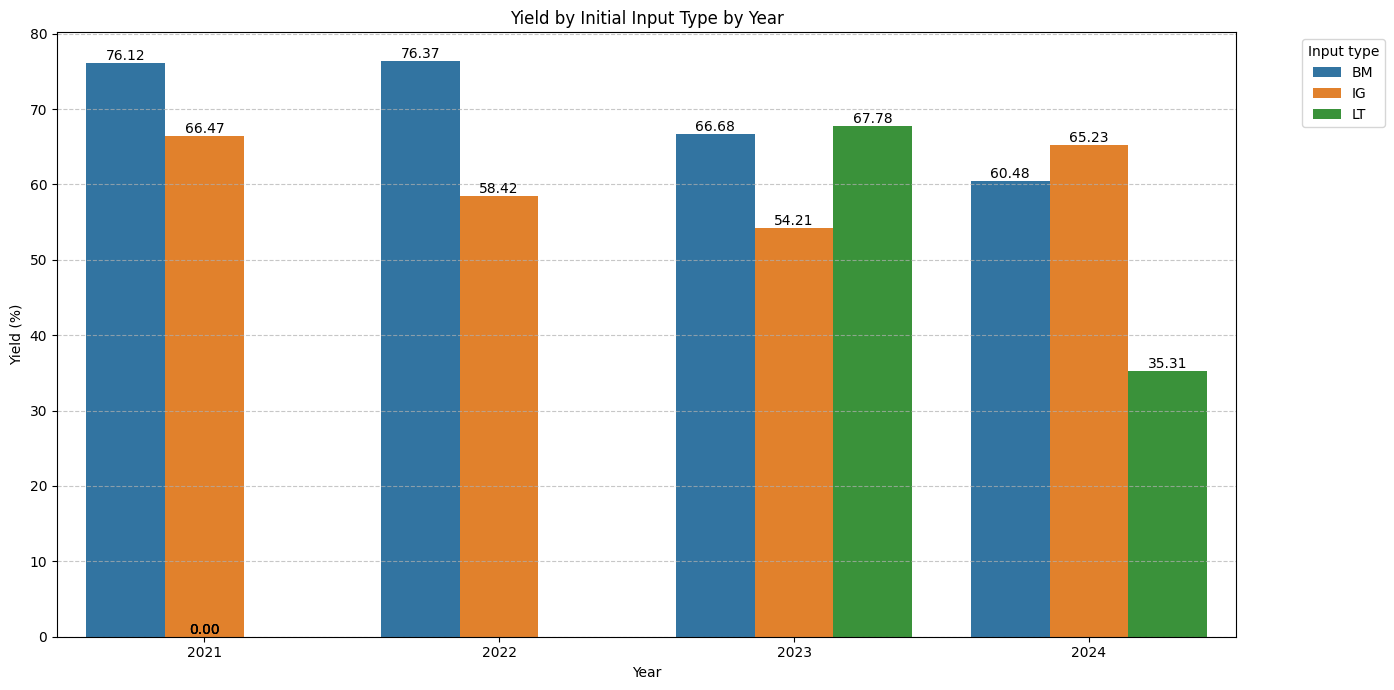

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가로축: 기준년, 세로축: 수율, 색상: 최초투입형태
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(data=summary, x='기준년', y='수율', hue='최초투입형태')

# 막대 위에 값 표시하기
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(format(height, '.2f'),
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center',
                      xytext=(0, 5),  # 수직으로 텍스트 위치 조정
                      textcoords='offset points')

plt.title('Yield by Initial Input Type by Year')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.legend(title='Input type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)  # x축 레이블이 겹치지 않도록 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()

In [15]:
# 조건에 따라 필터링 (형태가 '사각' 또는 '세모'이며 소재유무가 'Y')
filtered_df = df[(df['형태'].isin(['WR', 'RB'])) & (df['강관소재유무'] == 'N') & (df['최초투입형태'].isin(['BM','IG']))]

# 제품 형태별로 년도별 집계
summary = filtered_df.groupby(['최초투입형태', '기준년']).agg({
    '최초투입중량': 'sum',
    '최종생산중량': 'sum'
}).reset_index()

# 수율 계산
summary['수율'] = (summary['최종생산중량'] / summary['최초투입중량']*100).round(2)

# 결과 출력
#print(summary)
summary.head(20)

,최초투입형태,기준년,최초투입중량,최종생산중량,수율
0,BM,2021,179846,136898,76.12
1,BM,2022,603249,460679,76.37
2,BM,2023,926939,618129,66.68
3,BM,2024,841421,508873,60.48
4,IG,2021,880740,585406,66.47
5,IG,2022,454478,265502,58.42
6,IG,2023,461971,250426,54.21
7,IG,2024,603615,393711,65.23


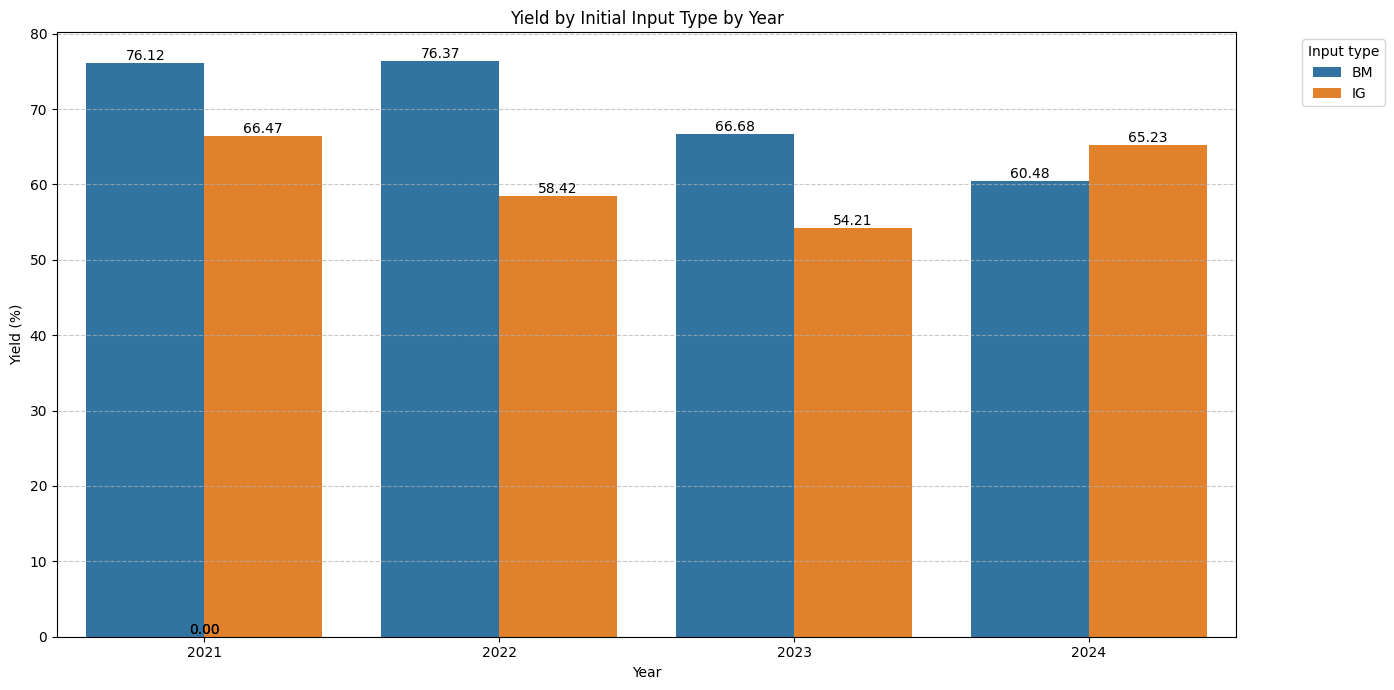

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가로축: 기준년, 세로축: 수율, 색상: 최초투입형태
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(data=summary, x='기준년', y='수율', hue='최초투입형태')

# 막대 위에 값 표시하기
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(format(height, '.2f'),
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center',
                      xytext=(0, 5),  # 수직으로 텍스트 위치 조정
                      textcoords='offset points')

plt.title('Yield by Initial Input Type by Year')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.legend(title='Input type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)  # x축 레이블이 겹치지 않도록 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()

In [17]:
import numpy as np

df_pivot =filtered_df.pivot_table(
    index = ["최초투입형태","기준년","반기"],
    #columns = ""
    values= ["최초투입중량","최종생산중량"],
    aggfunc=np.sum
    )

df_pivot['수율'] = (df_pivot['최종생산중량'] / df_pivot['최초투입중량'] * 100).round(1)

df_pivot

C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\2640570027.py:3: FutureWarning: The provided callable <function sum at 0x000001BBB6C5E340> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pivot =filtered_df.pivot_table(


최종생산중량  최초투입중량    수율
최초투입형태 기준년  반기                       
BM     2021 상반기  113269  147910  76.6
            하반기   23629   31936  74.0
       2022 상반기  300015  390997  76.7
            하반기  160664  212252  75.7
       2023 상반기  286694  376894  76.1
            하반기  331435  550045  60.3
       2024 상반기  205056  335831  61.1
            하반기  303817  505590  60.1
IG     2021 상반기  221142  340223  65.0
            하반기  364264  540517  67.4
       2022 상반기  212855  353993  60.1
            하반기   52647  100485  52.4
       2023 상반기  102237  183693  55.7
            하반기  148189  278278  53.3
       2024 상반기  264311  413994  63.8
            하반기  129400  189621  68.2

In [18]:
#2024년 월별 
import numpy as np
import pandas as pd

# 연도 범위 설정
start_year = 2024  # 시작 연도
end_year = 2024    # 종료 연도


# 조건에 따라 필터링 (형태가 '사각' 또는 '세모'이며 소재유무가 'Y')
filtered_df2 = df[(df['형태'].isin(['WR', 'RB'])) & (df['강관소재유무'] == 'N') & 
                  (df['최초투입형태'].isin(['BM','IG'])) &
                  (df['기준년'].astype(int).between(start_year, end_year))]

# 월별실적 피벗 테이블
df_pivot_monthly =filtered_df2.pivot_table(
    index = ["최초투입형태","기준년월"],
    #columns = ""
    values= ["최초투입중량","최종생산중량"],
    aggfunc=np.sum
    )

df_pivot_monthly['수율'] = (df_pivot_monthly['최종생산중량'] / df_pivot_monthly['최초투입중량'] * 100).round(1)

# 분기별 실적 피벗 테이블
df_pivot_quarterly = filtered_df2.pivot_table(
    index=["최초투입형태", "분기"],
    values=["최초투입중량", "최종생산중량"],
    aggfunc=np.sum
)
df_pivot_quarterly['수율'] = (df_pivot_quarterly['최종생산중량'] / df_pivot_quarterly['최초투입중량'] * 100).round(1)

# 반기별 실적 피벗 테이블
df_pivot_half_year = filtered_df2.pivot_table(
    index=["최초투입형태", "반기"],
    values=["최초투입중량", "최종생산중량"],
    aggfunc=np.sum
)
df_pivot_half_year['수율'] = (df_pivot_half_year['최종생산중량'] / df_pivot_half_year['최초투입중량'] * 100).round(1)

# 전체 실적
df_pivot_total = filtered_df2.pivot_table(
    index=["최초투입형태"],
    values=["최초투입중량", "최종생산중량"],
    aggfunc=np.sum
)
df_pivot_total['수율'] = (df_pivot_total['최종생산중량'] / df_pivot_total['최초투입중량'] * 100).round(1)
df_pivot_total.index = pd.MultiIndex.from_product([df_pivot_total.index, ["전체"]])

# 원하는 순서대로 월, 분기, 반기 실적을 자동으로 정렬하는 order 리스트 생성
order = []

# 월 사이에 분기와 반기 실적 추가
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        month_str = f"{year}{str(month).zfill(2)}"
        order.append(month_str)
        if month == 3:
            order.append("1분기")
        elif month == 6:
            order.append("2분기")
            order.append("상반기")
        elif month == 9:
            order.append("3분기")
        elif month == 12:
            order.append("4분기")
            order.append("하반기")

# 전체 추가
order.append("전체")

# 데이터프레임 결합
final_df = pd.concat([df_pivot_monthly, df_pivot_quarterly, df_pivot_half_year, df_pivot_total])

# MultiIndex의 level 0, 1로 명확히 인덱스 재정렬
final_index = pd.MultiIndex.from_product([final_df.index.levels[0], order], names=final_df.index.names)
final_df = final_df.reindex(final_index)

# NaN 값 제거
final_df.dropna(how='all', inplace=True)

# 결과 출력
final_df

C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\3200492514.py:16: FutureWarning: The provided callable <function sum at 0x000001BBB6C5E340> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pivot_monthly =filtered_df2.pivot_table(
C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\3200492514.py:26: FutureWarning: The provided callable <function sum at 0x000001BBB6C5E340> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pivot_quarterly = filtered_df2.pivot_table(
C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\3200492514.py:34: FutureWarning: The provided callable <function sum at 0x000001BBB6C5E340> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep

최종생산중량    최초투입중량    수율
최초투입형태                                 
BM     202401   90531.0  133006.0  68.1
       202402   20858.0   34595.0  60.3
       202403       0.0    3968.0   0.0
       1분기     111389.0  171569.0  64.9
       202404   19204.0   27291.0  70.4
       202405   47498.0   86388.0  55.0
       202406   26965.0   50583.0  53.3
       2분기      93667.0  164262.0  57.0
       상반기     205056.0  335831.0  61.1
       202407   13090.0   19262.0  68.0
       202408    8374.0   36452.0  23.0
       202409   80854.0  131267.0  61.6
       3분기     102318.0  186981.0  54.7
       202410  180058.0  279827.0  64.3
       202411   21441.0   38782.0  55.3
       4분기     201499.0  318609.0  63.2
       하반기     303817.0  505590.0  60.1
       전체      508873.0  841421.0  60.5
IG     202401   52758.0   83764.0  63.0
       202402   49568.0   74452.0  66.6
       1분기     102326.0  158216.0  64.7
       202404   76413.0  121601.0  62.8
       202405   62094.0   92780.0  66.9
       202406   23478.0   41397.0  56.7
       2분기     161985.0  255778.0  63.3
       상반기     264311.0  413994.0  63.8
       202407  109185.0  159207.0  68.6
       202408    2733.0    4576.0  59.7
       202409    6914.0   10639.0  65.0
       3분기     118832.0  174422.0  68.1
       202410    2076.0    3058.0  67.9
       202411    8492.0   12141.0  69.9
       4분기      10568.0   15199.0  69.5
       하반기     129400.0  189621.0  68.2
       전체      393711.0  603615.0  65.2

In [19]:
df_pivot_monthly

최종생산중량  최초투입중량    수율
최초투입형태 기준년월                        
BM     202401   90531  133006  68.1
       202402   20858   34595  60.3
       202403       0    3968   0.0
       202404   19204   27291  70.4
       202405   47498   86388  55.0
       202406   26965   50583  53.3
       202407   13090   19262  68.0
       202408    8374   36452  23.0
       202409   80854  131267  61.6
       202410  180058  279827  64.3
       202411   21441   38782  55.3
IG     202401   52758   83764  63.0
       202402   49568   74452  66.6
       202404   76413  121601  62.8
       202405   62094   92780  66.9
       202406   23478   41397  56.7
       202407  109185  159207  68.6
       202408    2733    4576  59.7
       202409    6914   10639  65.0
       202410    2076    3058  67.9
       202411    8492   12141  69.9

In [20]:
df_pivot_quarterly

최종생산중량  최초투입중량    수율
최초투입형태 분기                       
BM     1분기  111389  171569  64.9
       2분기   93667  164262  57.0
       3분기  102318  186981  54.7
       4분기  201499  318609  63.2
IG     1분기  102326  158216  64.7
       2분기  161985  255778  63.3
       3분기  118832  174422  68.1
       4분기   10568   15199  69.5

In [21]:
df_pivot_half_year

최종생산중량  최초투입중량    수율
최초투입형태 반기                       
BM     상반기  205056  335831  61.1
       하반기  303817  505590  60.1
IG     상반기  264311  413994  63.8
       하반기  129400  189621  68.2

In [22]:
df_pivot_total

,,최종생산중량,최초투입중량,수율
최초투입형태,,,,
BM,전체,508873,841421,60.5
IG,전체,393711,603615,65.2


C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\270662004.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['기간'] = filtered_df['기준년월'].apply(categorize_period)
C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\270662004.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['기간'] = filtered_df['기간'].astype(CategoricalDtype(categories=period_order, ordered=True))
C:\Users\CTE22-213\AppData\Local\Temp\ipykernel_1184\270662004.py:44: FutureWarning: The default of observed=Fals

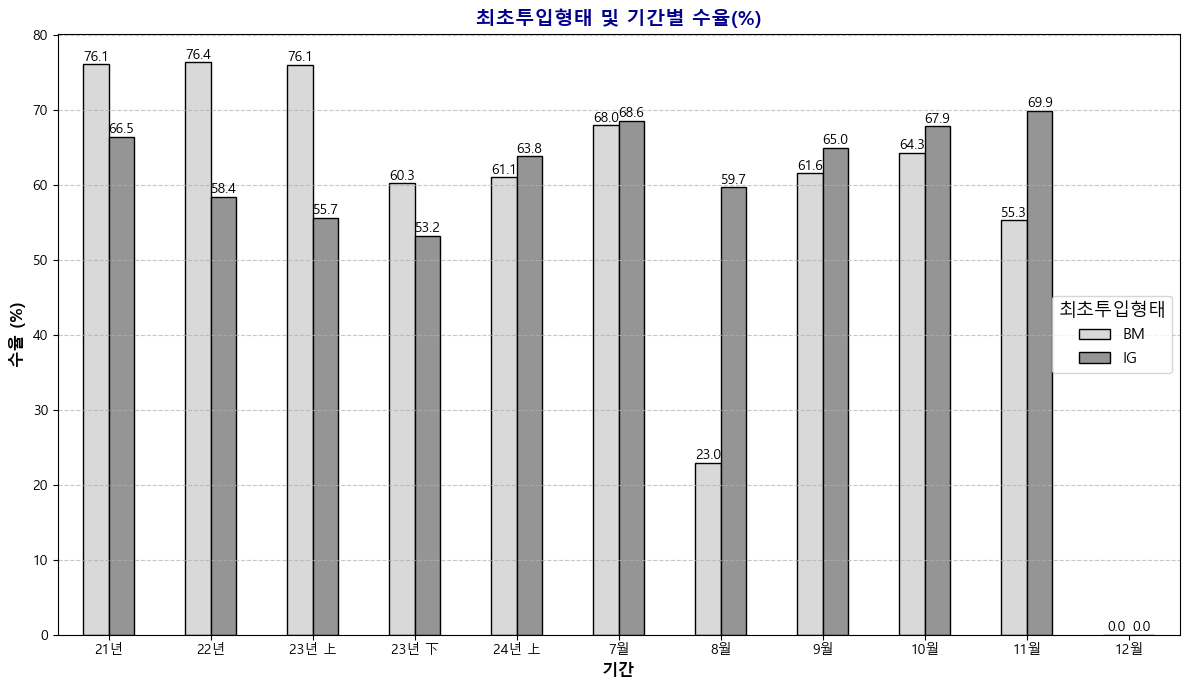

결과가 '기간별_수율.csv'로 저장되었습니다.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
from pandas.api.types import CategoricalDtype  # CategoricalDtype을 가져옵니다.

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # 또는 'NanumGothic'으로 변경 가능
plt.rc('axes', unicode_minus=False)  # 마이너스 기호가 깨지는 문제 해결

# X축 구간 설정 함수
def categorize_period(기준년월):
    if str(기준년월).startswith('2021'):
        return '21년'
    elif str(기준년월).startswith('2022'):
        return '22년'
    elif '202301' <= str(기준년월) <= '202306':
        return '23년 上'
    elif '202307' <= str(기준년월) <= '202312':
        return '23년 下'
    elif '202401' <= str(기준년월) <= '202406':
        return '24년 上'
    elif str(기준년월) == '202407':
        return '7월'
    elif str(기준년월) == '202408':
        return '8월'
    elif str(기준년월) == '202409':
        return '9월'
    elif str(기준년월) == '202410':
        return '10월'
    elif str(기준년월) == '202411':
        return '11월'
    elif str(기준년월) == '202412':
        return '12월'
    return '기타'

# 새로운 컬럼 추가 및 카테고리 순서 지정
period_order = ['21년', '22년', '23년 上', '23년 下', '24년 上', '7월', '8월', '9월', '10월', '11월', '12월','기타']
filtered_df['기간'] = filtered_df['기준년월'].apply(categorize_period)
filtered_df['기간'] = filtered_df['기간'].astype(CategoricalDtype(categories=period_order, ordered=True))

# 형상 및 기간별 평균 효율 계산
df_grouped = filtered_df.groupby(['기간', '최초투입형태']).agg({
    '최종생산중량': 'sum',
    '최초투입중량': 'sum'
}).reset_index()

# '기타' 제외
df_grouped = df_grouped[df_grouped['기간'] != '기타']

# Y값 계산 (생산/투입 * 100)
df_grouped['수율'] = (df_grouped['최종생산중량'] / df_grouped['최초투입중량']) * 100
df_grouped['수율'] = df_grouped['수율'].round(2)  # 소수점 1자리까지 반올림

# 형상 및 기간별 효율을 피벗 테이블로 변환
df_pivot = df_grouped.pivot(index='기간', columns='최초투입형태', values='수율')

# 색상 팔레트 선택 (Seaborn 팔레트 사용)
palette = sns.color_palette("Greys", 3)  # coolwarm, Set2, Paired, Greys 등 다양한 팔레트를 선택 가능

# 그래프 그리기
value=df_pivot.plot(kind='bar', figsize=(12, 7), color=palette, edgecolor='black')

# 막대 위에 값 표시
for p in value.patches:
    value.annotate(f'{p.get_height():.1f}',  # Y값 소수점 1자리까지
                (p.get_x() + p.get_width() / 2., p.get_height()),  # 좌표
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),  # 텍스트 위치 조정
                textcoords='offset points')

# 그래프 레이블 및 제목 설정
plt.xlabel('기간', fontsize=12, fontweight='bold')
plt.ylabel('수율 (%)', fontsize=12, fontweight='bold')
plt.title('최초투입형태 및 기간별 수율(%)',fontsize=14, fontweight='bold', color='darkblue')
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # y축에 그리드 추가
plt.legend(title='최초투입형태', title_fontsize='13', fontsize=11)

# 레이아웃 조정
plt.tight_layout()

# 그래프를 이미지로 저장 (예: PNG 형식)
plt.savefig('최초투입형태 및 기간별 수율.png', format='png', dpi=300)  # dpi는 해상도 설정

# 그래프 보여주기
plt.show()

# 테이블을 CSV로 추출하기
output_file = '기간별_수율.csv'
df_pivot.to_csv(output_file, encoding='utf-8-sig')  # utf-8-sig 인코딩으로 저장하여 한글이 깨지지 않도록

print(f"결과가 '{output_file}'로 저장되었습니다.")